In [1]:
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from bayes_opt import BayesianOptimization
import xgboost

import seaborn as sns; sns.set_theme(color_codes=True)
import pandas as pd
import numpy as np

from datetime import datetime
import pickle
import json
import glob
import os

In [2]:
# point these at the training and validation csv files
training_data_path = os.path.join(os.getcwd(),'data/dam forecast train.csv')

val_data_path = os.path.join(os.getcwd(),'data/dam forecast val.csv')

In [3]:
# set location to save model
model_folder = os.getcwd()
model_name = 'dam_forecast_5-10-22.pkl'
model_path = os.path.join(model_folder,'data',model_name)
model_path

'/Users/nicholaswright/Documents/Dam-Forecast/data/dam_forecast_5-10-22.pkl'

In [4]:
# we limit the max dam size as large dams are note well represented in our dataset 
max_value = 20000

In [5]:
# load up training data, do some cleaning
training_data = pd.read_csv(training_data_path)
training_data = training_data.reindex(sorted(training_data.columns), axis=1)
training_data = (training_data[training_data['area'] < max_value])
training_data

,SRC_DATE,acq_date_dec,acq_month,acq_year,area,area_2,avgt_0_months before,avgt_10_months before,avgt_11_months before,avgt_12_months before,...,rain_12_months before,rain_1_months before,rain_2_months before,rain_3_months before,rain_4_months before,rain_5_months before,rain_6_months before,rain_7_months before,rain_8_months before,rain_9_months before
0,20191216,2019.923077,12,2019,1499.986376,0.000000,22.075863,22.532957,24.789293,22.234226,...,69.268257,18.543798,32.006516,61.439262,35.894455,16.539648,88.088707,4.661098,31.547087,156.626801
1,20191216,2019.923077,12,2019,1957.925202,0.000000,22.010427,22.456602,24.717672,22.165726,...,73.195740,19.394297,34.531719,64.828262,38.369305,17.053242,91.522308,4.671404,34.583828,161.743271
2,20191216,2019.923077,12,2019,56.557682,0.000000,22.056850,22.542746,24.760044,22.226084,...,66.735779,18.249218,31.475410,60.696507,35.672646,16.840359,88.612167,4.817034,31.435335,156.489532
3,20191216,2019.923077,12,2019,620.839041,69.919793,21.282856,21.827082,23.865013,21.477997,...,72.046654,19.497202,38.455097,70.509048,42.860733,19.531702,110.724152,5.098410,46.165367,167.635620
4,20191216,2019.923077,12,2019,911.591665,85.853539,21.605618,22.146124,24.230387,21.803089,...,72.164078,19.490854,37.583042,69.094116,42.032280,18.774553,105.230629,4.771717,42.998913,166.344070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122355,20110314,2011.230769,3,2011,4690.590130,3356.800411,17.374683,11.195005,15.898821,19.154816,...,68.224213,59.891136,207.040710,78.528412,102.634651,96.229622,99.338455,116.911240,49.259342,40.513008
122356,20110314,2011.230769,3,2011,4209.619407,3706.714804,17.949766,11.530720,16.314760,19.665329,...,72.367729,83.379341,199.137802,79.470657,122.322914,88.567139,80.849838,115.938957,38.986027,28.328760
122357,20110314,2011.230769,3,2011,5667.357300,4151.021853,17.390991,11.228916,15.928892,19.164637,...,68.039749,57.796932,206.213806,79.184158,99.488831,96.697891,99.108482,115.774055,49.661472,40.927601
122358,20110314,2011.230769,3,2011,5681.396963,4562.555806,17.821377,11.494183,16.251537,19.555471,...,70.387558,76.052864,207.578339,71.201523,125.417290,89.132225,85.937271,107.952812,40.516605,32.805397


In [6]:
t_names = []
r_names = []
for col_name in training_data.columns:
    if  'avgt' in col_name:
        t_names.append(col_name)
    if 'rain' in col_name:
        r_names.append(col_name)
t_names

['avgt_0_months before',
 'avgt_10_months before',
 'avgt_11_months before',
 'avgt_12_months before',
 'avgt_1_months before',
 'avgt_2_months before',
 'avgt_3_months before',
 'avgt_4_months before',
 'avgt_5_months before',
 'avgt_6_months before',
 'avgt_7_months before',
 'avgt_8_months before',
 'avgt_9_months before']

In [7]:
# load up validation data and to some sorting
val_data = pd.read_csv(val_data_path)
val_data = val_data.reindex(sorted(val_data.columns), axis=1)
val_data = (val_data[val_data['area'] < max_value])

val_data.head()

,SRC_DATE,acq_date_dec,acq_month,acq_year,area,area_2,avgt_0_months before,avgt_10_months before,avgt_11_months before,avgt_12_months before,...,rain_12_months before,rain_1_months before,rain_2_months before,rain_3_months before,rain_4_months before,rain_5_months before,rain_6_months before,rain_7_months before,rain_8_months before,rain_9_months before
0,20151012,2015.769231,10,2015,1467.191148,400.256079,18.635481,20.496225,18.559628,16.436865,...,30.197670,20.906387,47.989525,31.595964,39.587959,28.022364,43.507568,22.958355,5.184834,3.242137
1,20160808,2016.615385,8,2016,7575.018970,5781.220903,16.349541,20.394827,17.614573,16.606274,...,104.356178,42.576038,253.462769,54.635857,63.877918,185.935028,84.719727,168.723022,55.986111,104.954948
2,20150329,2015.230769,3,2015,2028.126533,581.212166,15.383942,12.471212,14.250165,17.330566,...,20.296410,26.169157,61.649181,20.376518,38.139423,19.012955,27.550816,38.407516,52.971111,84.799873
3,20151215,2015.923077,12,2015,569.161178,317.463008,19.587343,20.264559,19.108833,17.489389,...,56.603233,51.825485,8.417039,51.016552,103.335541,90.978836,44.701668,103.889351,55.203209,72.892220
4,20160416,2016.307692,4,2016,3367.296500,508.559500,19.199778,13.545030,14.191324,18.163313,...,27.370653,55.944176,3.469017,44.472813,4.695564,25.031998,3.818929,4.354647,73.195625,74.399857


In [8]:
# remove val data from training data
val_file_names = val_data['file_name'].to_list()

training_data = training_data[~training_data.file_name.isin(val_file_names)]

In [9]:
training_data

,SRC_DATE,acq_date_dec,acq_month,acq_year,area,area_2,avgt_0_months before,avgt_10_months before,avgt_11_months before,avgt_12_months before,...,rain_12_months before,rain_1_months before,rain_2_months before,rain_3_months before,rain_4_months before,rain_5_months before,rain_6_months before,rain_7_months before,rain_8_months before,rain_9_months before
0,20191216,2019.923077,12,2019,1499.986376,0.000000,22.075863,22.532957,24.789293,22.234226,...,69.268257,18.543798,32.006516,61.439262,35.894455,16.539648,88.088707,4.661098,31.547087,156.626801
1,20191216,2019.923077,12,2019,1957.925202,0.000000,22.010427,22.456602,24.717672,22.165726,...,73.195740,19.394297,34.531719,64.828262,38.369305,17.053242,91.522308,4.671404,34.583828,161.743271
2,20191216,2019.923077,12,2019,56.557682,0.000000,22.056850,22.542746,24.760044,22.226084,...,66.735779,18.249218,31.475410,60.696507,35.672646,16.840359,88.612167,4.817034,31.435335,156.489532
3,20191216,2019.923077,12,2019,620.839041,69.919793,21.282856,21.827082,23.865013,21.477997,...,72.046654,19.497202,38.455097,70.509048,42.860733,19.531702,110.724152,5.098410,46.165367,167.635620
4,20191216,2019.923077,12,2019,911.591665,85.853539,21.605618,22.146124,24.230387,21.803089,...,72.164078,19.490854,37.583042,69.094116,42.032280,18.774553,105.230629,4.771717,42.998913,166.344070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122355,20110314,2011.230769,3,2011,4690.590130,3356.800411,17.374683,11.195005,15.898821,19.154816,...,68.224213,59.891136,207.040710,78.528412,102.634651,96.229622,99.338455,116.911240,49.259342,40.513008
122356,20110314,2011.230769,3,2011,4209.619407,3706.714804,17.949766,11.530720,16.314760,19.665329,...,72.367729,83.379341,199.137802,79.470657,122.322914,88.567139,80.849838,115.938957,38.986027,28.328760
122357,20110314,2011.230769,3,2011,5667.357300,4151.021853,17.390991,11.228916,15.928892,19.164637,...,68.039749,57.796932,206.213806,79.184158,99.488831,96.697891,99.108482,115.774055,49.661472,40.927601
122358,20110314,2011.230769,3,2011,5681.396963,4562.555806,17.821377,11.494183,16.251537,19.555471,...,70.387558,76.052864,207.578339,71.201523,125.417290,89.132225,85.937271,107.952812,40.516605,32.805397


In [10]:
# view all training data columns
training_data.columns

Index(['SRC_DATE', 'acq_date_dec', 'acq_month', 'acq_year', 'area', 'area_2',
       'avgt_0_months before', 'avgt_10_months before',
       'avgt_11_months before', 'avgt_12_months before',
       'avgt_1_months before', 'avgt_2_months before', 'avgt_3_months before',
       'avgt_4_months before', 'avgt_5_months before', 'avgt_6_months before',
       'avgt_7_months before', 'avgt_8_months before', 'avgt_9_months before',
       'class', 'class_name', 'file_name', 'geometry', 'rain_0_months before',
       'rain_10_months before', 'rain_11_months before',
       'rain_12_months before', 'rain_1_months before', 'rain_2_months before',
       'rain_3_months before', 'rain_4_months before', 'rain_5_months before',
       'rain_6_months before', 'rain_7_months before', 'rain_8_months before',
       'rain_9_months before'],
      dtype='object')

In [11]:
# set a list oif columns to drop, the model will not see these
drop_list = ['area_2','file_name', 'SRC_DATE','geometry','acq_year','acq_month','acq_date_dec','class','class_name']

In [12]:
# remove the drop list and setup target df
train_X = training_data.drop(columns=drop_list)
train_y = training_data[['area_2']]
print(train_y.head())
train_X.head()

      area_2
0   0.000000
1   0.000000
2   0.000000
3  69.919793
4  85.853539


,area,avgt_0_months before,avgt_10_months before,avgt_11_months before,avgt_12_months before,avgt_1_months before,avgt_2_months before,avgt_3_months before,avgt_4_months before,avgt_5_months before,...,rain_12_months before,rain_1_months before,rain_2_months before,rain_3_months before,rain_4_months before,rain_5_months before,rain_6_months before,rain_7_months before,rain_8_months before,rain_9_months before
0,1499.986376,22.075863,22.532957,24.789293,22.234226,20.396746,17.926054,15.415278,12.961130,13.086934,...,69.268257,18.543798,32.006516,61.439262,35.894455,16.539648,88.088707,4.661098,31.547087,156.626801
1,1957.925202,22.010427,22.456602,24.717672,22.165726,20.336300,17.855085,15.332343,12.882524,13.011043,...,73.195740,19.394297,34.531719,64.828262,38.369305,17.053242,91.522308,4.671404,34.583828,161.743271
2,56.557682,22.056850,22.542746,24.760044,22.226084,20.390297,17.952702,15.478308,13.054444,13.186954,...,66.735779,18.249218,31.475410,60.696507,35.672646,16.840359,88.612167,4.817034,31.435335,156.489532
3,620.839041,21.282856,21.827082,23.865013,21.477997,19.747135,17.428568,15.065031,12.862777,13.064048,...,72.046654,19.497202,38.455097,70.509048,42.860733,19.531702,110.724152,5.098410,46.165367,167.635620
4,911.591665,21.605618,22.146124,24.230387,21.803089,20.026794,17.639698,15.219195,12.937696,13.106893,...,72.164078,19.490854,37.583042,69.094116,42.032280,18.774553,105.230629,4.771717,42.998913,166.344070


In [13]:
# setup validation sets
val_X = val_data.drop(columns=drop_list)
val_y = val_data[['area_2']].copy()
print(train_y.head())
print(train_X.shape)
train_X.head()

      area_2
0   0.000000
1   0.000000
2   0.000000
3  69.919793
4  85.853539
(108847, 27)


,area,avgt_0_months before,avgt_10_months before,avgt_11_months before,avgt_12_months before,avgt_1_months before,avgt_2_months before,avgt_3_months before,avgt_4_months before,avgt_5_months before,...,rain_12_months before,rain_1_months before,rain_2_months before,rain_3_months before,rain_4_months before,rain_5_months before,rain_6_months before,rain_7_months before,rain_8_months before,rain_9_months before
0,1499.986376,22.075863,22.532957,24.789293,22.234226,20.396746,17.926054,15.415278,12.961130,13.086934,...,69.268257,18.543798,32.006516,61.439262,35.894455,16.539648,88.088707,4.661098,31.547087,156.626801
1,1957.925202,22.010427,22.456602,24.717672,22.165726,20.336300,17.855085,15.332343,12.882524,13.011043,...,73.195740,19.394297,34.531719,64.828262,38.369305,17.053242,91.522308,4.671404,34.583828,161.743271
2,56.557682,22.056850,22.542746,24.760044,22.226084,20.390297,17.952702,15.478308,13.054444,13.186954,...,66.735779,18.249218,31.475410,60.696507,35.672646,16.840359,88.612167,4.817034,31.435335,156.489532
3,620.839041,21.282856,21.827082,23.865013,21.477997,19.747135,17.428568,15.065031,12.862777,13.064048,...,72.046654,19.497202,38.455097,70.509048,42.860733,19.531702,110.724152,5.098410,46.165367,167.635620
4,911.591665,21.605618,22.146124,24.230387,21.803089,20.026794,17.639698,15.219195,12.937696,13.106893,...,72.164078,19.490854,37.583042,69.094116,42.032280,18.774553,105.230629,4.771717,42.998913,166.344070


In [14]:
# save out metadata to json, this is usefull when running predictions
meta_dict = {'col_names':list(train_X.columns),
            'model_path':model_path,
            'creation_date':str(datetime.today().strftime('%Y-%m-%d'))}

with open(model_path.replace('.pkl','.json'), 'w') as fp:
    json.dump(meta_dict, fp)

In [15]:
model_path

'/Users/nicholaswright/Documents/Dam-Forecast/data/dam_forecast_5-10-22.pkl'

In [16]:
def train_model(learning_rate,n_estimators,max_depth,min_split_loss,min_child_weight,max_delta_step,subsample):

    n_estimators = round(n_estimators)
    max_depth = round(max_depth)
    xgb_reg = XGBRegressor(learning_rate = learning_rate, 
                               n_estimators = n_estimators,
                               max_depth=max_depth,
                               tree_method='hist',
                              )
    
    xgb_reg.fit(train_X, train_y, eval_set=[(train_X, train_y)],verbose = 0)

    y_pred = xgb_reg.predict(val_X)
    y_pred = y_pred*(y_pred>0)
    
    model_mean_error = mean_absolute_error(val_data['area_2'].to_numpy(), y_pred)
            
    return(-model_mean_error)

In [17]:
pbounds = {'learning_rate': (0.1, 0.5), 'n_estimators': (10, 700),'max_depth': (1,15),
          'min_split_loss': (0,1),'min_child_weight': (0,2),'max_delta_step': (0,10),
          'subsample': (0,1)}

In [18]:
optimizer = BayesianOptimization(
    f=train_model,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

In [19]:
optimizer.maximize(
    init_points=5,
    n_iter=0,
)

|   iter    |  target   | learni... | max_de... | max_depth | min_ch... | min_sp... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -397.6    |  0.2668   |  7.203    |  1.002    |  0.6047   |  0.1468   |  73.71    |  0.1863   |
|  2        | -343.6    |  0.2382   |  3.968    |  8.543    |  0.8384   |  0.6852   |  151.1    |  0.8781   |
|  3        | -339.3    |  0.111    |  6.705    |  6.842    |  1.117    |  0.1404   |  146.7    |  0.8007   |
|  4        | -361.0    |  0.4873   |  3.134    |  10.69    |  1.753    |  0.8946   |  68.68    |  0.03905  |
|  5        | -358.6    |  0.1679   |  8.781    |  2.377    |  0.8422   |  0.9579   |  377.9    |  0.6919   |


In [133]:
best_pers = optimizer.max
best_pers

{'target': -56.731446110335085,
 'params': {'learning_rate': 0.11095503727917047,
  'max_delta_step': 6.704675101784022,
  'max_depth': 6.842267233139777,
  'min_child_weight': 1.1173796568915033,
  'min_split_loss': 0.14038693859523377,
  'n_estimators': 146.69002746856637,
  'subsample': 0.8007445686755367}}

In [134]:
def train_fin_model(learning_rate,n_estimators,max_depth,min_split_loss,min_child_weight,max_delta_step,subsample):

    n_estimators = round(n_estimators)
    max_depth = round(max_depth)
    xgb_reg = XGBRegressor(learning_rate = learning_rate, 
                               n_estimators = n_estimators,
                               max_depth=max_depth,                        
                               tree_method='hist',            
                              )
    xgb_reg.fit(train_X, train_y, eval_set=[(train_X, train_y)],verbose = 0)
    
    return(xgb_reg)

In [135]:
xgb_reg = train_fin_model(**best_pers['params'])

In [136]:
# run prediction on validation set
y_pred = xgb_reg.predict(val_X)
y_pred = y_pred*(y_pred>0)
val_y['preds'] = [value for value in y_pred]

[(0.0, 20000.0)]

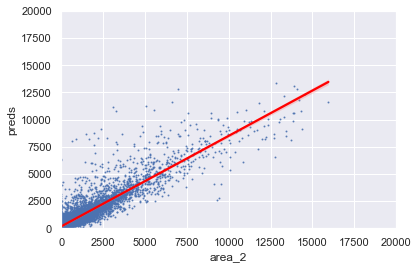

In [137]:
# plot up validation data preds vs measured values
ax = sns.regplot(x="area_2", y="preds", data=val_y,
                 scatter_kws={'s':1},
                 line_kws={"color": "red"})

ax.set(ylim=(0, max_value))
ax.set(xlim=(0, max_value))

In [138]:
# use numpy to calc the line of best fit equation
np.polyfit(val_y['area_2'], val_y['preds'], 1)

array([  0.83279781, 178.17905907])

In [119]:
# calc the model error and abs error 
val_y['error'] = val_y['preds']-val_data['area_2']
val_y['abs_error'] = abs(val_y['error'])
val_y.head()

,area_2,preds,error,abs_error,dist_from_mean
0,400.256079,294.496857,-105.759222,105.759222,615.010308
1,5781.220903,4037.703613,-1743.517290,1743.517290,4765.954516
2,581.212166,623.764954,42.552787,42.552787,434.054221
3,317.463008,229.667862,-87.795146,87.795146,697.803379
4,508.559500,911.181519,402.622019,402.622019,506.706887


In [120]:
# calc the mean abs model error
model_mean_error = val_y['abs_error'].mean()
model_mean_error

339.298468993802

In [121]:
# we can now compare the model to if we had just predicted the mean values for each row
# calc the overall mean from the measured values
mean_value = val_y['area_2'].mean()
# calc the abs distance each row is from the mean
val_y['dist_from_mean'] = abs(val_y['area_2']-mean_value)
# calc the mean distance from the mean, this is comparable to the model_mean_error value above
mean_dist_from_mean = val_y['dist_from_mean'].mean()
mean_dist_from_mean

885.8515476619349

In [122]:
# we can now compare the model_mean_error with the mean_dist_from_mean
'The model is explaining '+f"{1-model_mean_error/mean_dist_from_mean:.0%}" +' of the variance'

'The model is explaining 62% of the variance'

In [123]:
# save model to disk
pickle.dump(xgb_reg, open(model_path, "wb"))

In [48]:
model_path

'/Users/nicholaswright/Documents/Dam-Forecast/data/dam_forecast_5-10-22.pkl'